# Kalman filter for Particule Tracing

## Environment

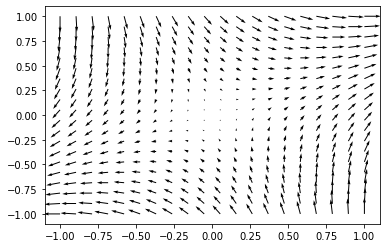

In [110]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## STATE VARIABLES

T = 20
dt = 0.01
q = 100
sigma_noise = 0.1
R = (sigma_noise**2)*np.identity(2) #measurement noise

## VECTOR FIELD 
## We start with f_linear represented by F

def f_circle(x,y):
    return np.array([-y/np.sqrt(x**2 + y**2),x/np.sqrt(x**2 + y**2)])

def f_delta(x,y):
    return np.array([x*y,1])

def f_linear(x,y):
    return np.array((x+y,x-y))

F = np.array([
        [1,0,dt,0],
        [0,1,0,dt],
        [q*dt,q*dt,1,0],
        [q*dt,-q*dt,0,1]
    ])

## NEXT STATE FUNCTION

def next_state(X,f):
    X_new = X.copy()
    X_new[0:2] = X[0:2]+dt*X[2:4]
    X_new[2:4] = X[2:4]+q*dt*f(X[0],X[1])
    return X_new

## PLOTTING

def plot_field(f):
    A,B = np.meshgrid(np.linspace(-1,1,20),np.linspace(-1,1,20))
    u,v = f(A,B)
    plt.quiver(A,B,u,v)
    
plot_field(f_linear)

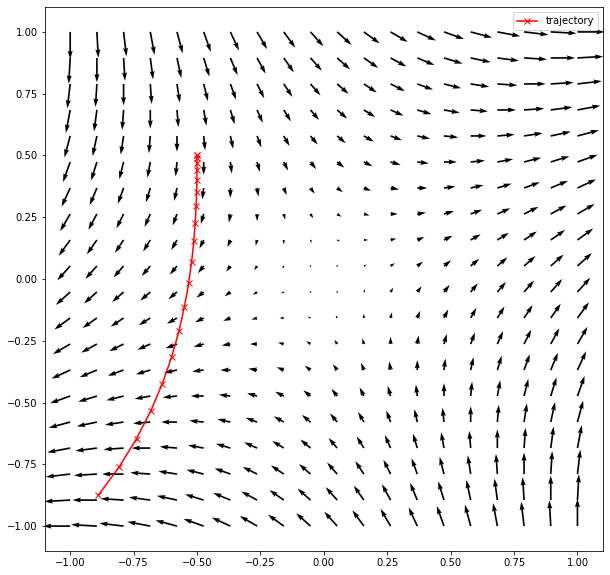

In [114]:
## REAL TRAJECTORY

def trajectory(X0,f=f_circle,T=10,process_noise_std=0):
    """
    X0: initial state
    f: vector field
    T: number of timesteps
    process_noise_std: standard deviation of process noise
    """
    X = np.zeros(shape = (T,4))
    X[0] = X0
    for t in range(1,T):
        X[t] = next_state(X[t-1],f)+process_noise_std*np.random.normal(size=4)
    return X

X0 = np.array([-0.5,0.5,0,0])
X = trajectory(X0, f_linear,T,process_noise_std=0)
X_pn = trajectory(X0, f_linear,T,process_noise_std=0.01)

plt.figure(figsize=(10,10))
plt.plot(X[:,0],X[:,1], color ="red",marker="x",label="trajectory")
#plt.plot(X_pn[:,0],X_pn[:,1], color ="green",marker="x",label="trajectory with process noise")
plot_field(f_linear)
plt.legend()
plt.show()

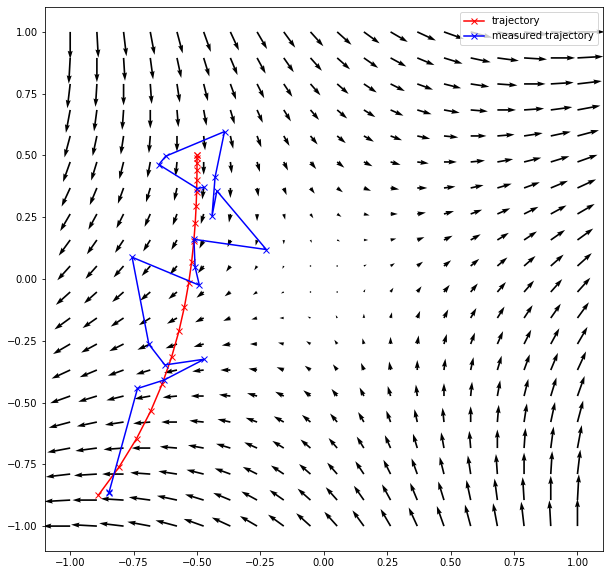

In [115]:
## OBSERVATION MODEL

def observation(X,R):
    Xn = X.copy()[:,:2]
    Xn = Xn + np.random.multivariate_normal(mean = np.zeros(2),cov=R,size = len(Xn))
    return Xn

Xobs = observation(X,R)
plt.figure(figsize=(10,10))
plt.plot(X[:,0],X[:,1], color ="red",marker="x",label="trajectory")
plt.plot(Xobs[:,0],Xobs[:,1], color ="blue",marker="x",label="measured trajectory")
plot_field(f_linear)
plt.legend()
plt.show()

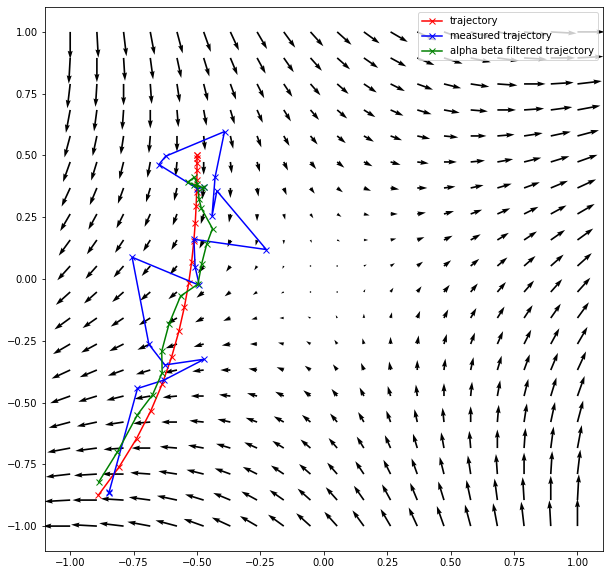

In [116]:
## Alpha Beta FILTER 

def alpha_beta_filter(prev_Xh,new_meas,alpha=0.8,beta=0.2):
    new_X = next_state(prev_Xh.copy(),f_linear)
    new_X[:2] = alpha*new_X[:2]+beta*new_meas
    return new_X

def apply_filter(the_filter,Xobs):
    T,_ = Xobs.shape
    Xfiltered0 = np.zeros(4)
    Xfiltered0[:2] = Xobs[0]
    Xfiltered = [Xfiltered0]
    for t in range(1,T):
        Xfiltered.append(the_filter(*(Xfiltered[-1],Xobs[t])))
    return np.array(Xfiltered)

Xfiltered = apply_filter(alpha_beta_filter,Xobs)

plt.figure(figsize=(10,10))
plt.plot(X[:,0],X[:,1], color ="red",marker="x",label="trajectory")
plt.plot(Xobs[:,0],Xobs[:,1], color ="blue",marker="x",label="measured trajectory")
plt.plot(Xfiltered[:,0],Xfiltered[:,1], color ="green",marker="x",label="alpha beta filtered trajectory")
plot_field(f_linear)
plt.legend()
plt.show()

# MLE Filter

In this filter, we assume there is no process noise. 

The sequence $(x_i)_{i\leq T} = (F^ix_0)_{i\leq T}$ is therefore deterministic

We observe positions $(y_i)_{i\leq T} = (HF^ix_0)_{i\leq T}$ that follow distribution $\mathcal{N}\left(
\begin{pmatrix}
Hx_0\\
HFx_0\\
...\\
HF^Tx_0
\end{pmatrix},
\begin{pmatrix}
R,0,...\\
0,R,...\\
0,0,...\\
...,0,R\end{pmatrix}
\right)$

Finding $x_0$ (and therefore estimating the trajectory) becomes a maximum likelihood problem, and we have

$$x_0^{MLE} = \text{argmin}_{x\in R^4}||Ax-b||_2^2$$

where $A = \begin{pmatrix}
Hx_0\\
HFx_0\\
...\\
HF^Tx_0
\end{pmatrix}$
and $b = \begin{pmatrix}
y_0\\
y_1\\
...\\
y_T
\end{pmatrix}$

In [117]:
k=20
X_MLE = []
for k in range(1,T):
    M = np.array([H.dot(np.linalg.matrix_power(F,i)) for i in range(k)])
    A = np.concatenate(M, axis=0)
    b = np.concatenate(Xobs[:k])
    x, residuals, rank, s = np.linalg.lstsq(A,b)
    X_MLE.append(H.dot(np.linalg.matrix_power(F,k)).dot(x))

X_MLE = np.array(X_MLE)

C:\Users\romai\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  import sys


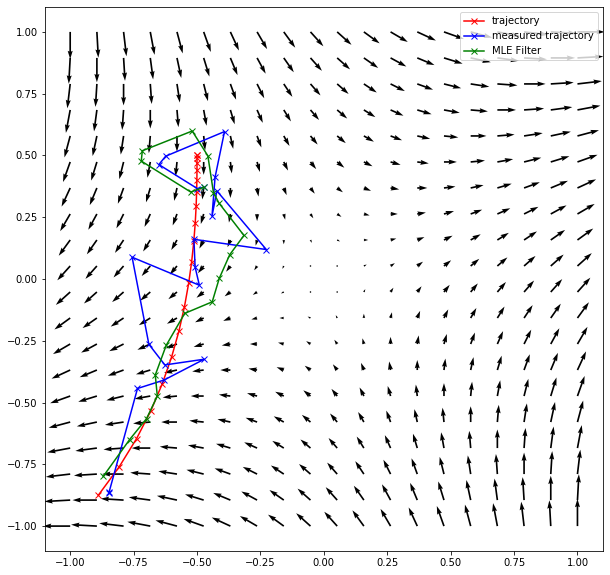

In [118]:
plt.figure(figsize=(10,10))
plt.plot(X[:,0],X[:,1], color ="red",marker="x",label="trajectory")
plt.plot(Xobs[:,0],Xobs[:,1], color ="blue",marker="x",label="measured trajectory")
plt.plot(X_MLE[:,0],X_MLE[:,1], color ="green",marker="x",label="MLE Filter")
plot_field(f_linear)
plt.legend()
plt.show()

Extended Kalman Filter:

Dynamical System Model

$x_{t} = Fx_{t-1}+w_t$
- System dynamics $F$ (is also local gradient in extended version)
- System noise $w_t\sim \mathcal{N}(0,Q)$

Observation Model (GPS: position only)

$z_t = Hx_t+ v_t$

- new observation $z_t$ >>> z
- obervation model $H = \begin{pmatrix}
1 & 0 & 0 & 0\\
0 & 1 & 0 & 0
\end{pmatrix}$
- observation noise $v_t \sim \mathcal{N}(0,R)$ (with $R = \sigma_{obs}I_{2\times2}$)

Estimation Model
- prior estimated state $\hat{x}_{t|t-1}$ >>> x_h_prev
- prior estimated covariance $\hat{P}_{t|t-1}$
- posterior estimated state $\hat{x}_{t|t}$
- posterior estimated covariance $\hat{P}_{t|t}$ >>> P

Prediction Rules
- a priori state estimation $\hat{x}_{t|t-1} = F\hat{x}_{t-1|t-1}$
- a priori covariance estimation $\hat{P}_{t|t-1} = F_{t-1}P_{t-1|t-1}F_{t-1}^T+Q$

Innovation Rules
- innovation estimation $i_t = z_t-H\hat{x}_{t|t-1}$
- innovation covariance $S_t = HP_{t|t-1}H^T+R$
- optimal Kalman gain $K_t = P_{t|t-1}H^TS_t^{-1}$
- a posteriori state estimation $\hat{x}_{t|t} = \hat{x}_{t|t-1}+K_ti_t$
- a posteriori covariance estimation $P_{t|t} = (I-K_tH)P_{t|t-1}$

In [119]:
## Extended Kalman Filter

H = np.array([[1,0,0,0],[0,1,0,0]])

    #F = np.array([
    #    [1,0,dt,0],
    #    [0,1,0,dt],
    #    [x*y/n,-x**2/n,1,0],
    #    [y**2/n,-x*y/n,0,1]
    #])

def extended_kalman_filter(x_h_prev,P_prev,z,R):
    #print("P_prev",P_prev)
    #print("x_prev",x_h_prev)
    x_h_priori = F.dot(x_h_prev)#next_state(x_h_prev,f_linear) #a priori state estimation
    #print("x_priori",x_h_priori)
    P_priori = F.dot(P_prev).dot(F.T)#+1*np.identity(4)
    #print("P_priori",P_priori)
    i = z-H.dot(x_h_priori) #innovation
    #print("z",z)
    S = H.dot(P_priori).dot(H.T)+R #innovation covariance
    #print("S",S)
    K = P_priori.dot(H.T).dot(np.linalg.inv(S)) #optimal Kalman gain
    #print("K",K)
    x_h_posteriori = x_h_priori + K.dot(i)
    #print("x_posteriori",x_h_posteriori)
    P_posteriori = (np.ones(4)-K.dot(H)).dot(P_priori)
    #print("P_posteriori",P_posteriori)
    return x_h_posteriori,P_posteriori

In [120]:
Xfiltered0 = np.zeros(4)
Xfiltered0[:2] = Xobs[0]
X_h = [Xfiltered0]
P0 = (0.01**2)*np.array([
    [1,0,0,0],
    [0,1,0,0],
    [0,0,0,0],
    [0,0,0,0]
])
P = [P0]
for t in range(1,len(Xobs)):
    res = extended_kalman_filter(X_h[-1],P[-1],Xobs[t],R)
    X_h.append(res[0])
    P.append(res[1])
X_h = np.array(X_h)

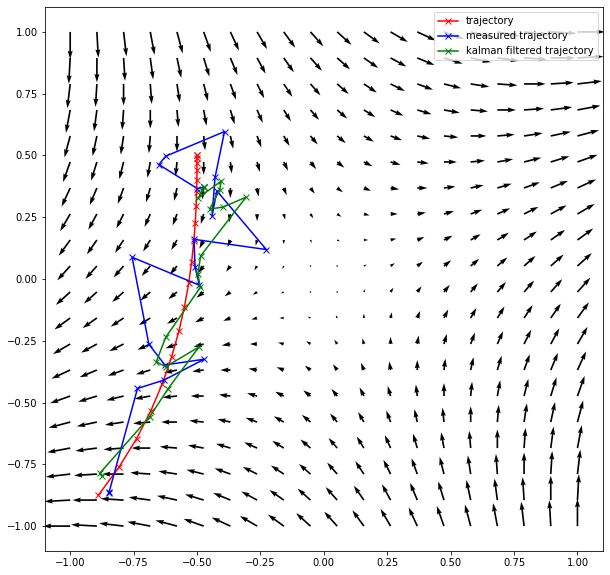

In [121]:
plt.figure(figsize=(10,10))
plt.plot(X[:,0],X[:,1], color ="red",marker="x",label="trajectory")
plt.plot(Xobs[:,0],Xobs[:,1], color ="blue",marker="x",label="measured trajectory")
plt.plot(X_h[:,0],X_h[:,1], color ="green",marker="x",label="kalman filtered trajectory")
plot_field(f_linear)
plt.legend()
plt.show()

Another attempt with Gaussian HMM

Dynamical System Model

- System dynamics $x_{i+1}=Ax_i$
- Transition matrix $A$
- First state $x_0 \sim \mathcal{N}(\mu_0,\Lambda_0)$

Observation Model (GPS: position only)

- observation $y_t = Cx_t+ w_t$
- obervation model $C = \begin{pmatrix}
1 & 0 & 0 & 0\\
0 & 1 & 0 & 0
\end{pmatrix}$
- observation noise $w_t \sim \mathcal{N}(0,R)$ (with $R = \sigma_{obs}I_{2\times2}$)

Initialisation

- Initialisation of J $J_0 = \Lambda_0^{-1}$ ##TO CHECK
- Initialisation of h $h_0 = J_0x_0$
- Initialisation of message $J_{0->1} = $

Message Building

- Message on J $J_{i->i+1} = $

In [ ]:
def GaussianBP(J_mess,h_mess)

In [ ]:
J = []


In [ ]:
J_mess